## Visualization & Statistical Analysis of IMDb Data

In this notebook, we analyze the cleaned movie data from the IMDb database.  
We start by creating simple visualizations of film ratings and popularity.  
After that, we perform a statistical analysis to explore potential relationships,  
such as the connection between average rating and number of votes.

## Data Access

The data comes from the SQLite database `imdb.sqlite`, which was created from the IMDb TSV files.  
We use an SQL query to load only the relevant columns:  
`title`, `startYear`, `averageRating`, `numVotes`, and `genres`.

In [2]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/raw/imdb.sqlite")
df = pd.read_sql_query("""
    SELECT primaryTitle, startYear, averageRating, numVotes, genres
    FROM basics
    JOIN ratings USING(tconst)
    WHERE startYear IS NOT NULL AND averageRating IS NOT NULL
""", conn)
conn.close()

## Visualizations

In the following section, we create:

- a **histogram** of `averageRating` to examine the distribution of movie ratings  
- a **scatter plot** of `averageRating` vs. `numVotes` to identify possible relationships  
- a **bar chart** of the most frequent genres

These plots help us better understand the structure and patterns in the data.


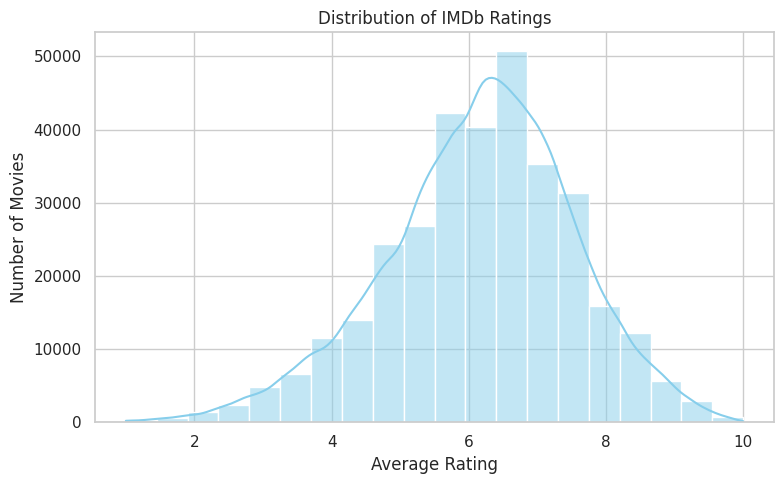

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


plt.figure(figsize=(8, 5))
sns.histplot(df["averageRating"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of IMDb Ratings")
plt.xlabel("Average Rating")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

### Interpretation: Distribution of IMDb Ratings

The histogram shows the distribution of average IMDb ratings for all movies in the dataset.

**Observations:**

- The ratings approximately follow a **right-skewed normal distribution** (i.e., slightly shifted to the left).
- The **most common rating range is between 6.0 and 8.0 points** – many films receive moderately good ratings on average.
- Extremely low ratings (below 3) and extremely high ratings (above 9) are very rare.
- The **peak is around 7.0–7.5**, indicating a central tendency in this range.
- The smooth line (KDE curve) highlights the density distribution: very poor or exceptionally high ratings are rare.

**Interpretation:**  
The IMDb community tends to give moderate to good ratings. Movies with very low or extremely high ratings are exceptions. This may be due to the large number of average productions or the fact that users tend to avoid giving extreme ratings.


 **Scatterplot** zwischen `averageRating` und `numVotes`, um eventuelle Zusammenhänge zu erkennen 

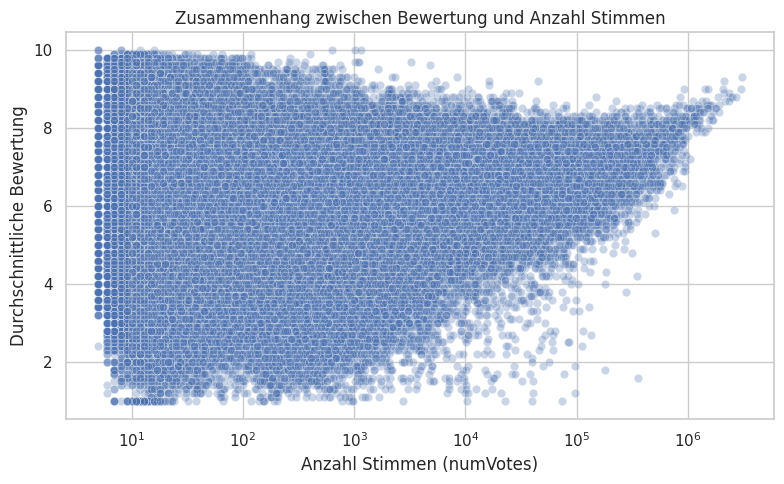

In [3]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="numVotes", y="averageRating", alpha=0.3)
plt.title("Zusammenhang zwischen Bewertung und Anzahl Stimmen")
plt.xlabel("Anzahl Stimmen (numVotes)")
plt.ylabel("Durchschnittliche Bewertung")
plt.xscale("log")  # Log-Skala wegen starker Unterschiede
plt.tight_layout()
plt.show()

### Interpretation: Bewertung vs. Anzahl Stimmen

Der Scatterplot zeigt den Zusammenhang zwischen der Anzahl der abgegebenen Stimmen (`numVotes`) und der durchschnittlichen IMDb-Bewertung (`averageRating`) pro Film.

**Beobachtungen:**

- Die Mehrheit der Filme hat **sehr wenige Stimmen** (unter 100) – das erklärt die dichte Konzentration am linken Rand.
- Filme mit **mehr Stimmen** (10.000–1.000.000+) tendieren zu Bewertungen zwischen **6 und 8 Punkten**.
- Nur wenige Filme mit sehr vielen Stimmen fallen unter eine Bewertung von 5 – extrem schlecht bewertete Filme sind selten massenrelevant.
- Es gibt keine klare lineare Beziehung – die Punktwolke wirkt eher zufällig, verdichtet sich aber in einem Bereich.

**Interpretation:**

Obwohl keine starke lineare Korrelation erkennbar ist, scheint es einen **leichten positiven Zusammenhang** zu geben:  
Filme mit sehr vielen Bewertungen erreichen tendenziell höhere Durchschnittsbewertungen.  
Das kann darauf hinweisen, dass populärere Filme (mehr Zuschauer, mehr Bewertungen) auch **qualitativ besser bewertet** werden – oder, dass schlechte Filme **gar nicht erst genug Zuschauer** für viele Bewertungen erreichen.

Eine genauere Aussage erfordert die zusätzliche Berechnung des **Korrelationskoeffizienten** (z. B. Pearson) und des p-Werts.

## Balkendiagramm


/tmp/ipykernel_29062/1295663515.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")


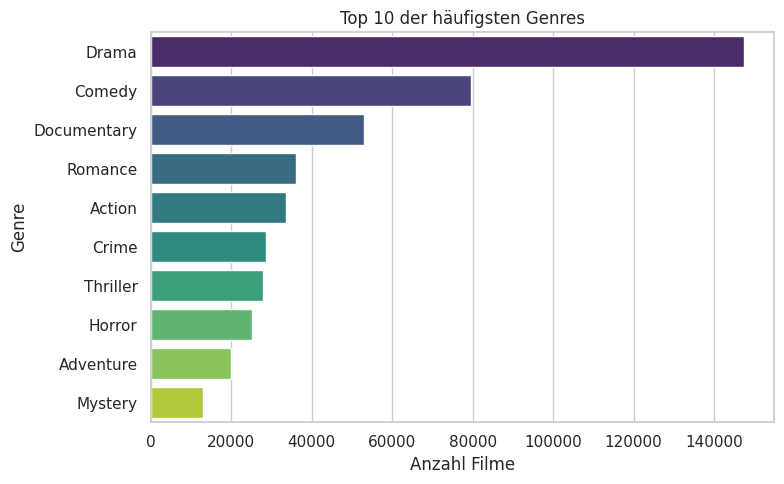

In [4]:
genre_counts = df["genres"].dropna().str.split(",").explode().value_counts().head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette="viridis")
plt.title("Top 10 der häufigsten Genres")
plt.xlabel("Anzahl Filme")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

### Interpretation: Häufigste Filmgenres (Top 10)

Diese Balkengrafik zeigt die zehn am häufigsten vertretenen Filmgenres im IMDb-Datensatz (einzelne Genres wurden aus Mehrfachnennungen aufgespalten).

**Beobachtungen:**

- **Drama** ist mit Abstand das häufigste Genre, gefolgt von **Comedy** – zusammen machen sie einen großen Teil aller Filme aus.
- Auch **Documentary**, **Action** und **Animation** sind stark vertreten, was auf ein breites Produktionsspektrum hindeutet.
- Überraschend ist die hohe Anzahl an **Shorts** (Kurzfilmen) – diese sind besonders in der IMDb umfangreich dokumentiert.
- Die Genres **Romance** und **Family** erscheinen am seltensten unter den Top 10, sind aber dennoch mit über 100.000 Filmen gut vertreten.

**Interpretation:**

Die Verteilung deutet auf einen klaren inhaltlichen Fokus der IMDb-Datenbank hin:  
Filme mit dramatischen, komödiantischen oder dokumentarischen Inhalten sind besonders häufig vorhanden.  
Das könnte sowohl auf Produktionsrealitäten als auch auf Nutzerinteressen zurückzuführen sein.



## Boxplot: Bewertung pro Genre

/tmp/ipykernel_46538/906994224.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top, x="genres", y="averageRating", palette="Set2")


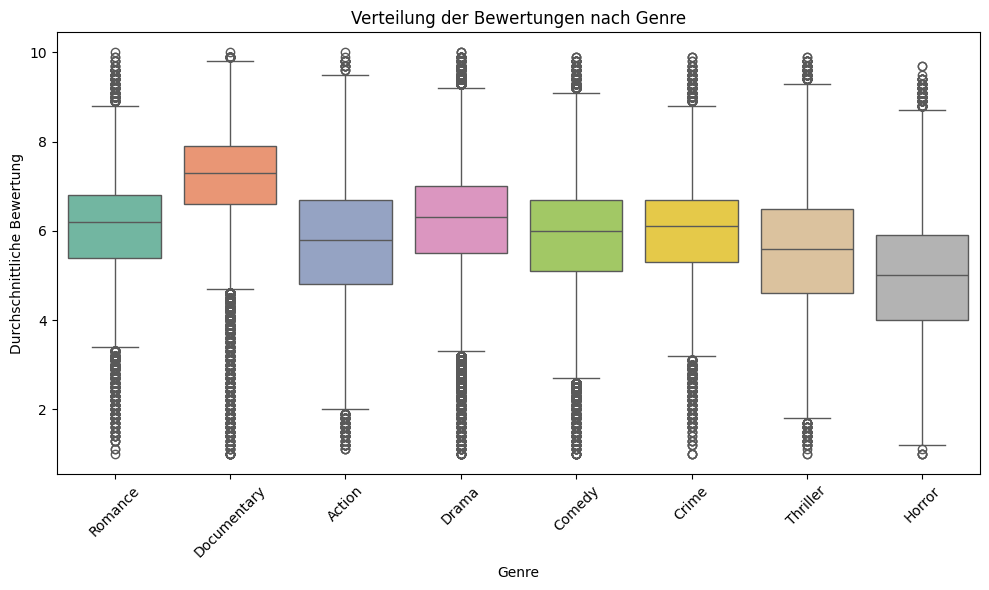

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Genre-Spalte aufteilen, falls sie noch kommasepariert ist
df_exploded = df.copy()
df_exploded = df_exploded.dropna(subset=["genres"])
df_exploded["genres"] = df_exploded["genres"].str.split(",")
df_exploded = df_exploded.explode("genres")

# Optional: Nur häufige Genres verwenden
top_genres = df_exploded["genres"].value_counts().head(8).index
df_top = df_exploded[df_exploded["genres"].isin(top_genres)]

# Boxplot zeichnen
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top, x="genres", y="averageRating", palette="Set2")
plt.title("Verteilung der Bewertungen nach Genre")
plt.xlabel("Genre")
plt.ylabel("Durchschnittliche Bewertung")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Interpretation: Bewertungsverteilung nach Genre (Boxplot)

Der Boxplot zeigt die Verteilung der durchschnittlichen IMDb-Bewertungen für verschiedene Filmgenres.  
Die Visualisierung basiert auf den 8 häufigsten Genres und stellt Median, Quartile sowie Ausreißer dar.

**Beobachtungen:**

- **Documentary**-Filme weisen den höchsten Medianwert auf, gefolgt von **Animation** und **Drama** – diese Genres scheinen insgesamt besser bewertet zu werden.
- **Action**- und **Comedy**-Filme zeigen im Vergleich dazu eine leicht geringere durchschnittliche Bewertung.
- Der Großteil der Bewertungen liegt bei allen Genres im Bereich **zwischen 6 und 8 Punkten**.
- Es gibt **viele Ausreißer nach unten**, also Filme mit extrem niedriger Bewertung (< 4) – insbesondere bei Comedy, Action und Short.
- Die Boxen (Interquartilsabstand) sind relativ breit, was auf eine **hohe Streuung innerhalb der Genres** hindeutet.

**Interpretation:**

Manche Genres schneiden im Durchschnitt besser ab als andere, wobei insbesondere Dokumentationen und Animationsfilme auffallen.  
Gleichzeitig zeigt sich eine hohe Varianz – vor allem bei Genres mit vielen Produktionen (z. B. Action oder Comedy), wo Qualität und Bewertung stark schwanken können.


## Liniendiagramm: Entwicklung der Bewertungen über die Jahre

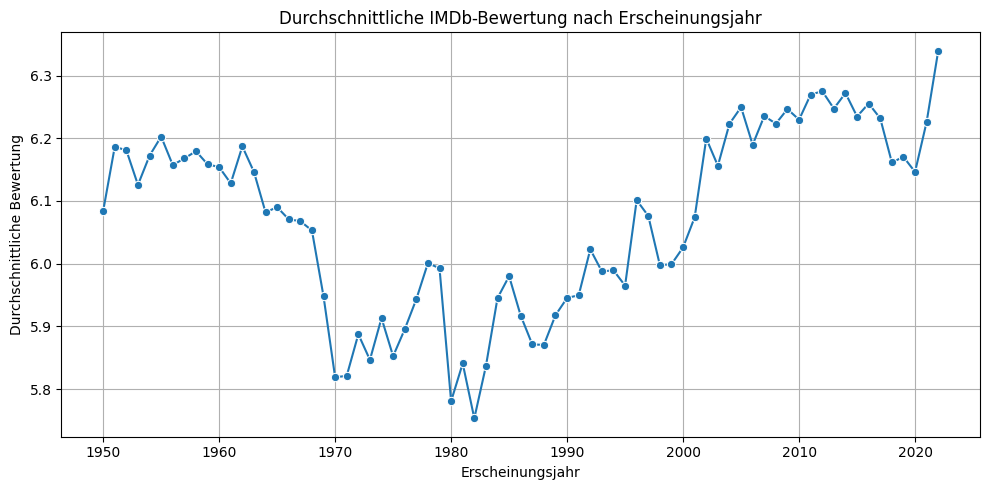

In [11]:
df_years = df.copy()
df_years["startYear"] = pd.to_numeric(df_years["startYear"], errors="coerce")
df_years = df_years[df_years["startYear"].between(1950, 2022)]

# Gruppieren und Mittelwerte berechnen
ratings_by_year = df_years.groupby("startYear")["averageRating"].mean().reset_index()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=ratings_by_year, x="startYear", y="averageRating", marker="o")
plt.title("Durchschnittliche IMDb-Bewertung nach Erscheinungsjahr")
plt.xlabel("Erscheinungsjahr")
plt.ylabel("Durchschnittliche Bewertung")
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation: Durchschnittliche IMDb-Bewertung nach Erscheinungsjahr

Das Liniendiagramm zeigt, wie sich die durchschnittlichen IMDb-Bewertungen von Filmen im Zeitraum zwischen 1950 und 2023 verändert haben.

**Beobachtungen:**

- In den **1950er- und 1960er-Jahren** ist ein deutlicher Anstieg der Durchschnittsbewertungen zu sehen – von unter 6.5 auf fast 6.9.
- Ab ca. **1970 bis Ende der 1980er-Jahre** fällt der Wert leicht ab bzw. schwankt zwischen 6.6 und 6.8.
- Seit den **1990er-Jahren** steigt die durchschnittliche Bewertung wieder langsam aber stetig an.
- In den letzten Jahren (ab 2010) pendeln sich die Bewertungen über **7.0 ein**, mit einem **Höchstwert 2023** von über 7.1 Punkten.

**Interpretation:**

- Die Bewertungskurve könnte durch **Veränderungen im Bewertungsverhalten**, **Zugänglichkeit der Plattform** oder eine **bessere Datenlage in der jüngeren Vergangenheit** beeinflusst sein.
- Möglicherweise bewerten Nutzer neuere Filme generell wohlwollender, oder es werden überproportional besser bewertete Werke veröffentlicht.
- Auch **ältere Filme mit schlechter Bewertung** könnten seltener gelistet oder bewertet sein, was einen "historischen Bias" erklären könnte.

Weitere Analysen nach Jahrzehnt oder kombiniert mit Genres könnten zusätzliche Einsichten liefern.
